# 使用MoveNet来检测姿态

MoveNet 是一个超快且准确的模型，可检测身体的 17 个关键点。该模型在 TF Hub 上提供两种变体，分别为 Lightning 和 Thunder。Lightning 用于延迟关键型应用，而 Thunder 用于需要高准确性的应用。在大多数现代台式机、笔记本电脑和手机上，这两种模型的运行速度都快于实时 (30+ FPS)，这对于实时的健身、健康和保健应用至关重要。



|image|video|
|-----|-----|
|<img src="ww.jpg" width="300"/> |<img src="output.gif" width="300"/>|
|<img src="ww3.jpg" width="300"/> |<img src="an.gif" width="300"/>|

## 可视化库和导入

In [1]:
!pip install -q imageio

In [2]:
!pip install -q opencv-python

In [ ]:
!pip install -q git+https://github.com/tensorflow/docs

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow_docs.vis import embed
import numpy as np
import cv2

# Import matplotlib libraries
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as patches

# Some modules to display an animation using imageio.
import imageio
from IPython.display import HTML, display

In [2]:
# Dictionary that maps from joint names to keypoint indices.
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

# Maps bones to a matplotlib color name.
KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

def _keypoints_and_edges_for_display(keypoints_with_scores,
                                     height,
                                     width,
                                     keypoint_threshold=0.11):
  """Returns high confidence keypoints and edges for visualization.

  Args:
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    height: height of the image in pixels.
    width: width of the image in pixels.
    keypoint_threshold: minimum confidence score for a keypoint to be
      visualized.

  Returns:
    A (keypoints_xy, edges_xy, edge_colors) containing:
      * the coordinates of all keypoints of all detected entities;
      * the coordinates of all skeleton edges of all detected entities;
      * the colors in which the edges should be plotted.
  """
  keypoints_all = []
  keypoint_edges_all = []
  edge_colors = []
  num_instances, _, _, _ = keypoints_with_scores.shape
  for idx in range(num_instances):
    kpts_x = keypoints_with_scores[0, idx, :, 1]
    kpts_y = keypoints_with_scores[0, idx, :, 0]
    kpts_scores = keypoints_with_scores[0, idx, :, 2]
    kpts_absolute_xy = np.stack(
        [width * np.array(kpts_x), height * np.array(kpts_y)], axis=-1)
    kpts_above_thresh_absolute = kpts_absolute_xy[
        kpts_scores > keypoint_threshold, :]
    keypoints_all.append(kpts_above_thresh_absolute)

    for edge_pair, color in KEYPOINT_EDGE_INDS_TO_COLOR.items():
      if (kpts_scores[edge_pair[0]] > keypoint_threshold and
          kpts_scores[edge_pair[1]] > keypoint_threshold):
        x_start = kpts_absolute_xy[edge_pair[0], 0]
        y_start = kpts_absolute_xy[edge_pair[0], 1]
        x_end = kpts_absolute_xy[edge_pair[1], 0]
        y_end = kpts_absolute_xy[edge_pair[1], 1]
        line_seg = np.array([[x_start, y_start], [x_end, y_end]])
        keypoint_edges_all.append(line_seg)
        edge_colors.append(color)
  if keypoints_all:
    keypoints_xy = np.concatenate(keypoints_all, axis=0)
  else:
    keypoints_xy = np.zeros((0, 17, 2))

  if keypoint_edges_all:
    edges_xy = np.stack(keypoint_edges_all, axis=0)
  else:
    edges_xy = np.zeros((0, 2, 2))
  return keypoints_xy, edges_xy, edge_colors


def draw_prediction_on_image(
    image, keypoints_with_scores, crop_region=None, close_figure=False,
    output_image_height=None):
  """Draws the keypoint predictions on image.

  Args:
    image: A numpy array with shape [height, width, channel] representing the
      pixel values of the input image.
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    crop_region: A dictionary that defines the coordinates of the bounding box
      of the crop region in normalized coordinates (see the init_crop_region
      function below for more detail). If provided, this function will also
      draw the bounding box on the image.
    output_image_height: An integer indicating the height of the output image.
      Note that the image aspect ratio will be the same as the input image.

  Returns:
    A numpy array with shape [out_height, out_width, channel] representing the
    image overlaid with keypoint predictions.
  """
  height, width, channel = image.shape
  aspect_ratio = float(width) / height
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
  # To remove the huge white borders
  fig.tight_layout(pad=0)
  ax.margins(0)
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  plt.axis('off')

  im = ax.imshow(image)
  line_segments = LineCollection([], linewidths=(4), linestyle='solid')
  ax.add_collection(line_segments)
  # Turn off tick labels
  scat = ax.scatter([], [], s=60, color='#FF1493', zorder=3)

  (keypoint_locs, keypoint_edges,
   edge_colors) = _keypoints_and_edges_for_display(
       keypoints_with_scores, height, width)

  line_segments.set_segments(keypoint_edges)
  line_segments.set_color(edge_colors)
  if keypoint_edges.shape[0]:
    line_segments.set_segments(keypoint_edges)
    line_segments.set_color(edge_colors)
  if keypoint_locs.shape[0]:
    scat.set_offsets(keypoint_locs)

  if crop_region is not None:
    xmin = max(crop_region['x_min'] * width, 0.0)
    ymin = max(crop_region['y_min'] * height, 0.0)
    rec_width = min(crop_region['x_max'], 0.99) * width - xmin
    rec_height = min(crop_region['y_max'], 0.99) * height - ymin
    rect = patches.Rectangle(
        (xmin,ymin),rec_width,rec_height,
        linewidth=1,edgecolor='b',facecolor='none')
    ax.add_patch(rect)

  fig.canvas.draw()
  image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
  image_from_plot = image_from_plot.reshape(
      fig.canvas.get_width_height()[::-1] + (3,))
  plt.close(fig)
  if output_image_height is not None:
    output_image_width = int(output_image_height / height * width)
    image_from_plot = cv2.resize(
        image_from_plot, dsize=(output_image_width, output_image_height),
         interpolation=cv2.INTER_CUBIC)
  return image_from_plot

def to_gif(images, fps):
  """Converts image sequence (4D numpy array) to gif."""
  imageio.mimsave('./animation.gif', images, fps=fps)
  return embed.embed_file('./animation.gif')

def progress(value, max=100):
  return HTML("""
      <progress
          value='{value}'
          max='{max}',
          style='width: 100%'
      >
          {value}
      </progress>
  """.format(value=value, max=max))

## 从 TF hub 加载模型

In [3]:
model_name = "movenet_lightning"

interpreter = tf.lite.Interpreter(model_path="lite-model_movenet_singlepose_thunder_tflite_float16_4.tflite")
interpreter.allocate_tensors()
def movenet(input_image):
    """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    model = module.signatures['serving_default']

    # SavedModel format expects tensor type of int32.
    input_image = tf.cast(input_image, dtype=tf.int32)
    # Run model inference.
    outputs = model(input_image)
    # Output is a [1, 1, 17, 3] tensor.
    keypoints_with_scores = outputs['output_0'].numpy()
    return keypoints_with_scores

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


## 单个图像示例  

本节演示对单个图像运行模型以预测 17 个人体关键点的最小工作示例。

<img src="ww.jpg" width="400"/>

## 加载输入图像

In [4]:
# Load the input image.
image_path = 'ww.jpg'
image = tf.io.read_file(image_path)
image = tf.image.decode_jpeg(image)

2023-10-30 09:57:44.391722: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-30 09:57:45.276607: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10396 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1
2023-10-30 09:57:45.277048: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 10410 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:02:00.0, compute capability: 6.1


## 设置图像的长度

In [5]:
input_size = 256

## 定义函数

In [6]:
 def movenet(input_image):
    """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    # TF Lite format expects tensor type of uint8.
    input_image = tf.cast(input_image, dtype=tf.uint8)
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    interpreter.set_tensor(input_details[0]['index'], input_image.numpy())
    # Invoke inference.
    interpreter.invoke()
    # Get the model prediction.
    keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
    return keypoints_with_scores

## 运行推断

/tmp/ipykernel_421733/3431570978.py:160: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


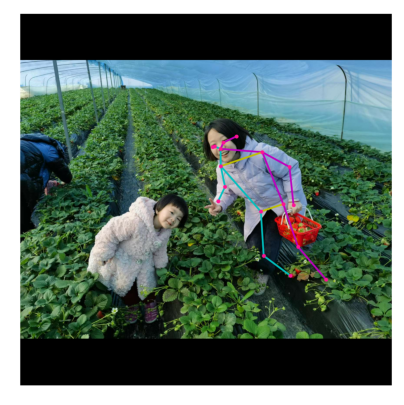

In [7]:
# Resize and pad the image to keep the aspect ratio and fit the expected size.
input_image = tf.expand_dims(image, axis=0)
input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

# Run model inference.
keypoints_with_scores = movenet(input_image)

# Visualize the predictions with image.
display_image = tf.expand_dims(image, axis=0)
display_image = tf.cast(tf.image.resize_with_pad(
    display_image, 1280, 1280), dtype=tf.int32)
output_overlay = draw_prediction_on_image(
    np.squeeze(display_image.numpy(), axis=0), keypoints_with_scores)

plt.figure(figsize=(5, 5))
plt.imshow(output_overlay)
_ = plt.axis('off')

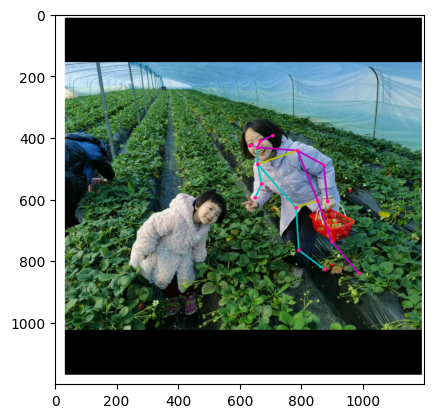

In [9]:
plt.imshow(output_overlay)

In [11]:
import matplotlib.image as mping
mping.imsave("ww3.jpg",output_overlay)

## 视频（图像序列）示例

本节演示当输入为帧序列时，如何根据前一帧的检测结果应用智能裁剪。这样模型可以将注意力和资源投入到主要主题上，从而在不牺牲速度的情况下获得更好的预测质量。  

我们可以先将视频转换为gif格式：  

ffmpeg -i wxt3.mp4 -ss 00:00:00.000 -pix_fmt rgb24  -r 10 -s 640x480 output.gif

<img src="output.gif" width="400"/>

## 加载视频

In [8]:
# Load the input image.
image_path = 'output.gif'
image = tf.io.read_file(image_path)
image = tf.image.decode_gif(image)

## Cropping Algorithm

In [9]:
# Confidence score to determine whether a keypoint prediction is reliable.
MIN_CROP_KEYPOINT_SCORE = 0.2

def init_crop_region(image_height, image_width):
  """Defines the default crop region.

  The function provides the initial crop region (pads the full image from both
  sides to make it a square image) when the algorithm cannot reliably determine
  the crop region from the previous frame.
  """
  if image_width > image_height:
    box_height = image_width / image_height
    box_width = 1.0
    y_min = (image_height / 2 - image_width / 2) / image_height
    x_min = 0.0
  else:
    box_height = 1.0
    box_width = image_height / image_width
    y_min = 0.0
    x_min = (image_width / 2 - image_height / 2) / image_width

  return {
    'y_min': y_min,
    'x_min': x_min,
    'y_max': y_min + box_height,
    'x_max': x_min + box_width,
    'height': box_height,
    'width': box_width
  }

def torso_visible(keypoints):
  """Checks whether there are enough torso keypoints.

  This function checks whether the model is confident at predicting one of the
  shoulders/hips which is required to determine a good crop region.
  """
  return ((keypoints[0, 0, KEYPOINT_DICT['left_hip'], 2] >
           MIN_CROP_KEYPOINT_SCORE or
          keypoints[0, 0, KEYPOINT_DICT['right_hip'], 2] >
           MIN_CROP_KEYPOINT_SCORE) and
          (keypoints[0, 0, KEYPOINT_DICT['left_shoulder'], 2] >
           MIN_CROP_KEYPOINT_SCORE or
          keypoints[0, 0, KEYPOINT_DICT['right_shoulder'], 2] >
           MIN_CROP_KEYPOINT_SCORE))

def determine_torso_and_body_range(
    keypoints, target_keypoints, center_y, center_x):
  """Calculates the maximum distance from each keypoints to the center location.

  The function returns the maximum distances from the two sets of keypoints:
  full 17 keypoints and 4 torso keypoints. The returned information will be
  used to determine the crop size. See determineCropRegion for more detail.
  """
  torso_joints = ['left_shoulder', 'right_shoulder', 'left_hip', 'right_hip']
  max_torso_yrange = 0.0
  max_torso_xrange = 0.0
  for joint in torso_joints:
    dist_y = abs(center_y - target_keypoints[joint][0])
    dist_x = abs(center_x - target_keypoints[joint][1])
    if dist_y > max_torso_yrange:
      max_torso_yrange = dist_y
    if dist_x > max_torso_xrange:
      max_torso_xrange = dist_x

  max_body_yrange = 0.0
  max_body_xrange = 0.0
  for joint in KEYPOINT_DICT.keys():
    if keypoints[0, 0, KEYPOINT_DICT[joint], 2] < MIN_CROP_KEYPOINT_SCORE:
      continue
    dist_y = abs(center_y - target_keypoints[joint][0]);
    dist_x = abs(center_x - target_keypoints[joint][1]);
    if dist_y > max_body_yrange:
      max_body_yrange = dist_y

    if dist_x > max_body_xrange:
      max_body_xrange = dist_x

  return [max_torso_yrange, max_torso_xrange, max_body_yrange, max_body_xrange]

def determine_crop_region(
      keypoints, image_height,
      image_width):
  """Determines the region to crop the image for the model to run inference on.

  The algorithm uses the detected joints from the previous frame to estimate
  the square region that encloses the full body of the target person and
  centers at the midpoint of two hip joints. The crop size is determined by
  the distances between each joints and the center point.
  When the model is not confident with the four torso joint predictions, the
  function returns a default crop which is the full image padded to square.
  """
  target_keypoints = {}
  for joint in KEYPOINT_DICT.keys():
    target_keypoints[joint] = [
      keypoints[0, 0, KEYPOINT_DICT[joint], 0] * image_height,
      keypoints[0, 0, KEYPOINT_DICT[joint], 1] * image_width
    ]

  if torso_visible(keypoints):
    center_y = (target_keypoints['left_hip'][0] +
                target_keypoints['right_hip'][0]) / 2;
    center_x = (target_keypoints['left_hip'][1] +
                target_keypoints['right_hip'][1]) / 2;

    (max_torso_yrange, max_torso_xrange,
      max_body_yrange, max_body_xrange) = determine_torso_and_body_range(
          keypoints, target_keypoints, center_y, center_x)

    crop_length_half = np.amax(
        [max_torso_xrange * 1.9, max_torso_yrange * 1.9,
          max_body_yrange * 1.2, max_body_xrange * 1.2])

    tmp = np.array(
        [center_x, image_width - center_x, center_y, image_height - center_y])
    crop_length_half = np.amin(
        [crop_length_half, np.amax(tmp)]);

    crop_corner = [center_y - crop_length_half, center_x - crop_length_half];

    if crop_length_half > max(image_width, image_height) / 2:
      return init_crop_region(image_height, image_width)
    else:
      crop_length = crop_length_half * 2;
      return {
        'y_min': crop_corner[0] / image_height,
        'x_min': crop_corner[1] / image_width,
        'y_max': (crop_corner[0] + crop_length) / image_height,
        'x_max': (crop_corner[1] + crop_length) / image_width,
        'height': (crop_corner[0] + crop_length) / image_height -
            crop_corner[0] / image_height,
        'width': (crop_corner[1] + crop_length) / image_width -
            crop_corner[1] / image_width
      }
  else:
    return init_crop_region(image_height, image_width)

def crop_and_resize(image, crop_region, crop_size):
  """Crops and resize the image to prepare for the model input."""
  boxes=[[crop_region['y_min'], crop_region['x_min'],
          crop_region['y_max'], crop_region['x_max']]]
  output_image = tf.image.crop_and_resize(
      image, box_indices=[0], boxes=boxes, crop_size=crop_size)
  return output_image

def run_inference(movenet, image, crop_region, crop_size):
  """Runs model inferece on the cropped region.

  The function runs the model inference on the cropped region and updates the
  model output to the original image coordinate system.
  """
  image_height, image_width, _ = image.shape
  input_image = crop_and_resize(
    tf.expand_dims(image, axis=0), crop_region, crop_size=crop_size)
  # Run model inference.
  keypoints_with_scores = movenet(input_image)
  # Update the coordinates.
  for idx in range(17):
    keypoints_with_scores[0, 0, idx, 0] = (
        crop_region['y_min'] * image_height +
        crop_region['height'] * image_height *
        keypoints_with_scores[0, 0, idx, 0]) / image_height
    keypoints_with_scores[0, 0, idx, 1] = (
        crop_region['x_min'] * image_width +
        crop_region['width'] * image_width *
        keypoints_with_scores[0, 0, idx, 1]) / image_width
  return keypoints_with_scores

## 使用裁剪算法运行推断

/tmp/ipykernel_420775/3431570978.py:160: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
/tmp/ipykernel_420775/3431570978.py:160: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
/tmp/ipykernel_420775/3431570978.py:160: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
/tmp/ipykernel_420775/3431570978.py:160: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releas

/tmp/ipykernel_420775/3431570978.py:160: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
/tmp/ipykernel_420775/3431570978.py:160: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
/tmp/ipykernel_420775/3431570978.py:160: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
/tmp/ipykernel_420775/3431570978.py:160: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releas


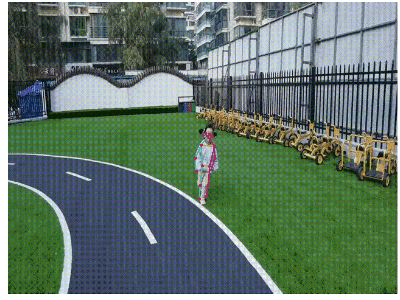

In [10]:
# Load the input image.
num_frames, image_height, image_width, _ = image.shape
crop_region = init_crop_region(image_height, image_width)

output_images = []
bar = display(progress(0, num_frames-1), display_id=True)
for frame_idx in range(num_frames):
  keypoints_with_scores = run_inference(
      movenet, image[frame_idx, :, :, :], crop_region,
      crop_size=[input_size, input_size])
  output_images.append(draw_prediction_on_image(
      image[frame_idx, :, :, :].numpy().astype(np.int32),
      keypoints_with_scores, crop_region=None,
      close_figure=True, output_image_height=300))
  crop_region = determine_crop_region(
      keypoints_with_scores, image_height, image_width)
  bar.update(progress(frame_idx, num_frames-1))

# Prepare gif visualization.
output = np.stack(output_images, axis=0)
to_gif(output, fps=10)

## 查看完整结果

<img src="an.gif" width="400"/>

## MoveNet 结构

MoveNet 是一种自下而上的估计模型，使用热图来准确定位人体关键点。 该架构由两个组件组成：特征提取器和一组预测头。 预测方案大致遵循 CenterNet，但有显着的变化，提高了速度和准确性。 所有模型均使用 TensorFlow 对象检测 API 进行训练。

MoveNet is a bottom-up estimation model, using heatmaps to accurately localize human keypoints. The architecture consists of two components: a feature extractor and a set of prediction heads. The prediction scheme loosely follows CenterNet, with notable changes that improve both speed and accuracy. All models are trained using the TensorFlow Object Detection API.

The feature extractor in MoveNet is MobileNetV2 with an attached feature pyramid network (FPN), which allows for a high resolution (output stride 4), semantically rich feature map output. There are four prediction heads attached to the feature extractor, responsible for densely predicting a:

MoveNet 中的特征提取器是带有附加特征金字塔网络 (FPN) 的 MobileNetV2，它允许高分辨率（输出步长 4）、语义丰富的特征图输出。 特征提取器连接有四个预测头，负责密集预测：

1. Person center heatmap: predicts the geometric center of person instances
2. Keypoint regression field: predicts full set of keypoints for a person, used for grouping keypoints into instances
3. Person keypoint heatmap: predicts the location of all keypoints, independent of person instances
4. 2D per-keypoint offset field: predicts local offsets from each output feature map pixel to the precise sub-pixel location of each keypoint
    

1. 人物中心热图：预测人物实例的几何中心  
2. 关键点回归字段：预测一个人的完整关键点集，用于将关键点分组到实例中  
3. 人物关键点热图：预测所有关键点的位置，与人物实例无关  
4. 2D 每关键点偏移字段：预测从每个输出特征图像素到每个关键点的精确子像素位置的局部偏移

<img src="MoveNetArchitecture.png" width="800"/>

Although these predictions are computed in parallel, one can gain insight into the model’s operation by considering the following sequence of operations:  

尽管这些预测是并行计算的，但可以通过考虑以下操作序列来深入了解模型的操作：

Step 1: The person center heatmap is used to identify the centers of all individuals in the frame, defined as the arithmetic mean of all keypoints belonging to a person. The location with the highest score (weighted by the inverse-distance from the frame center) is selected.  

步骤1：人物中心热图用于识别帧中所有个体的中心，定义为属于一个人的所有关键点的算术平均值。 选择得分最高的位置（按距帧中心的反距离加权）。  

Step 2: An initial set of keypoints for the person is produced by slicing the keypoint regression output from the pixel corresponding to the object center. Since this is a center-out prediction – which must operate over different scales – the quality of regressed keypoints will not be very accurate.  

步骤 2：通过对与对象中心对应的像素的关键点回归输出进行切片，生成人物的初始关键点集。 由于这是一个从中心向外的预测——必须在不同的尺度上运行——回归关键点的质量不会非常准确。  

Step 3: Each pixel in the keypoint heatmap is multiplied by a weight which is inversely proportional to the distance from the corresponding regressed keypoint. This ensures that we do not accept keypoints from background people, since they typically will not be in the proximity of regressed keypoints, and hence will have low resulting scores.  

步骤 3：关键点热图中的每个像素乘以一个权重，该权重与距相应回归关键点的距离成反比。 这确保了我们不接受来自背景人员的关键点，因为他们通常不会接近回归关键点，因此得到的分数较低。  

Step 4: The final set of keypoint predictions are selected by retrieving the coordinates of the maximum heatmap values in each keypoint channel. The local 2D offset predictions are then added to these coordinates to give refined estimates. See the figure below which illustrates these four steps.


步骤 4：通过检索每个关键点通道中最大热图值的坐标来选择最终的关键点预测集。 然后将局部 2D 偏移预测添加到这些坐标中以给出精确的估计。 请参见下图，它说明了这四个步骤。

<img src="MoveNetPostProcessing.png" width="600"/>

## 训练数据集

MoveNet 在两个数据集上进行训练：COCO 和一个名为 Active 的内部 Google 数据集。 虽然 COCO 是检测的标准基准数据集（由于其场景和尺度多样性），但它不适合健身和舞蹈应用，因为这些应用表现出具有挑战性的姿势和显着的运动模糊。 Active是通过在YouTube上的瑜伽、健身和舞蹈视频上标记关键点（采用COCO标准的17个身体关键点）来制作的。 每个视频中选择不超过三帧进行训练，以促进场景和个体的多样性。

对 Active 验证数据集的评估显示，相对于仅使用 COCO 训练的相同架构，性能有显着提升。 这并不奇怪，因为 COCO 很少展示极端姿势（例如瑜伽、俯卧撑、倒立等）的人。

## 优化

虽然在架构设计、后处理逻辑和数据选择方面投入了大量精力，使 MoveNet 成为高质量的检测器，但推理速度也得到了同等重视。 首先，选择 MobileNetV2 中的瓶颈层用于 FPN 中的横向连接。 同样，每个预测头中的卷积滤波器的数量也显着减少，以加快输出特征图的执行速度。 除第一个 MobileNetV2 层外，整个网络都使用深度可分离卷积。

MoveNet 被反复分析，发现并删除特别慢的操作。 例如，我们将 tf.math.top_k 替换为 tf.math.argmax，因为它的执行速度明显更快并且足以满足单人设置。

为了确保 TensorFlow.js 的快速执行，所有模型输出都打包到单个输出张量中，因此从 GPU 到 CPU 只需要一次下载。

也许最显着的加速是模型使用 192x192 输入（Thunder 为 256x256）。 为了抵消较低的分辨率，我们根据前一帧的检测应用智能裁剪。 这使得模型能够将注意力和资源集中在主要主题上，而不是背景上。

## 参考

1. [Next-Generation Pose Detection with MoveNet and TensorFlow.js](https://blog.tensorflow.org/2021/05/next-generation-pose-detection-with-movenet-and-tensorflowjs.html)